# **Task 3 Shravani Reddy**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
Accuracy: 0.6916705016106764

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.85      0.39      0.54      7230
         0.0       0.77      0.61      0.68     10961
         1.0       0.63      0.90      0.74     14404

    accuracy                           0.69     32595
   macro avg       0.75      0.64      0.65     32595
weighted avg       0.73      0.69      0.68     32595



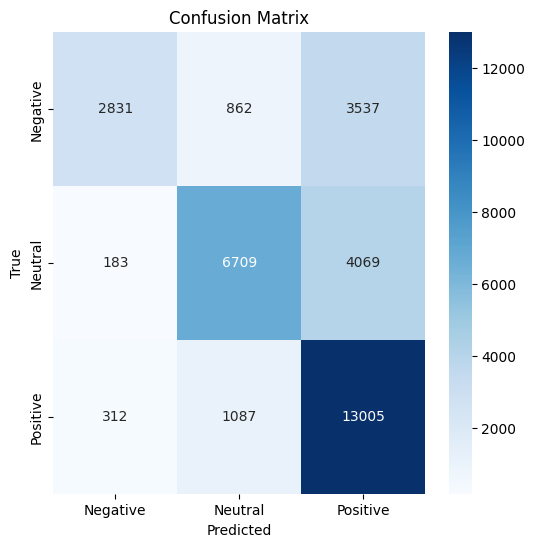

<ipython-input-5-783ddcdb5dcf>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette="viridis")


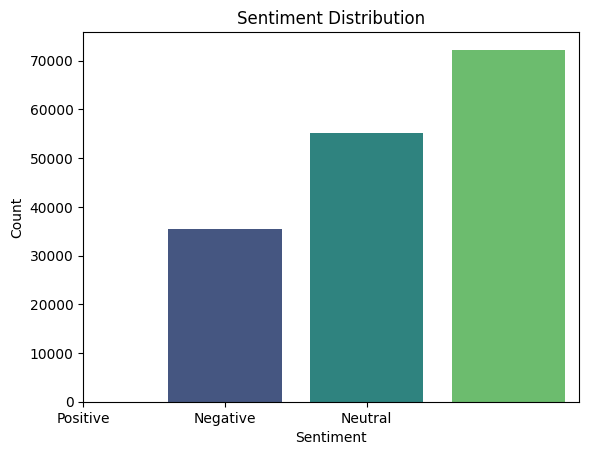

<ipython-input-5-783ddcdb5dcf>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=word_freq_df, palette="Blues_d")


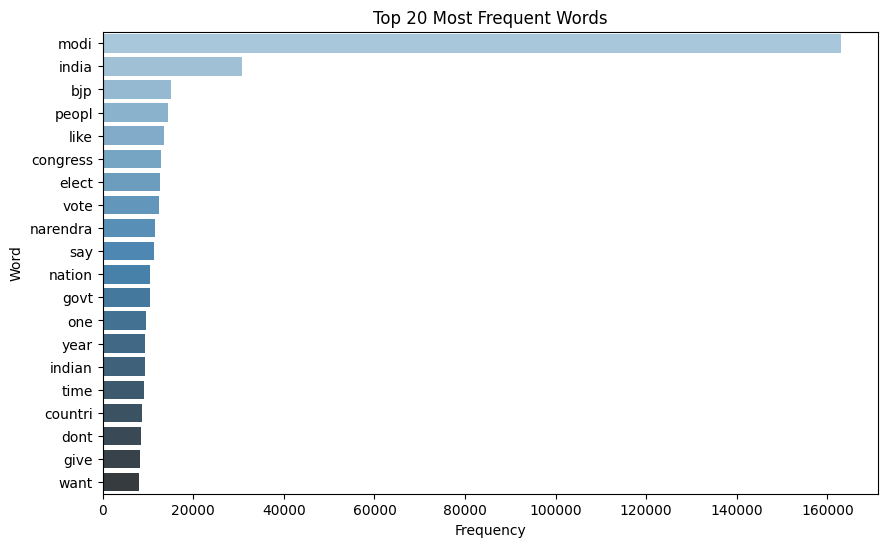

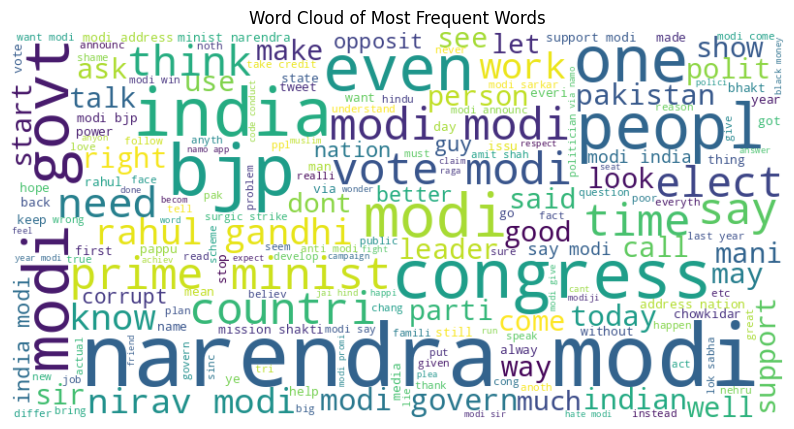

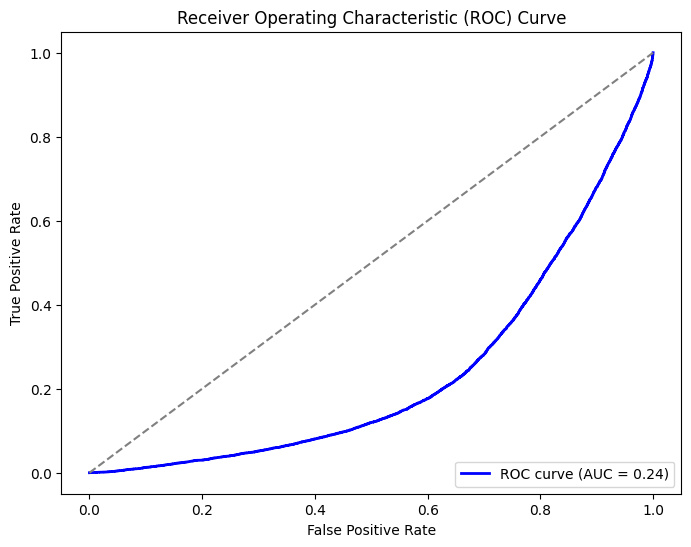

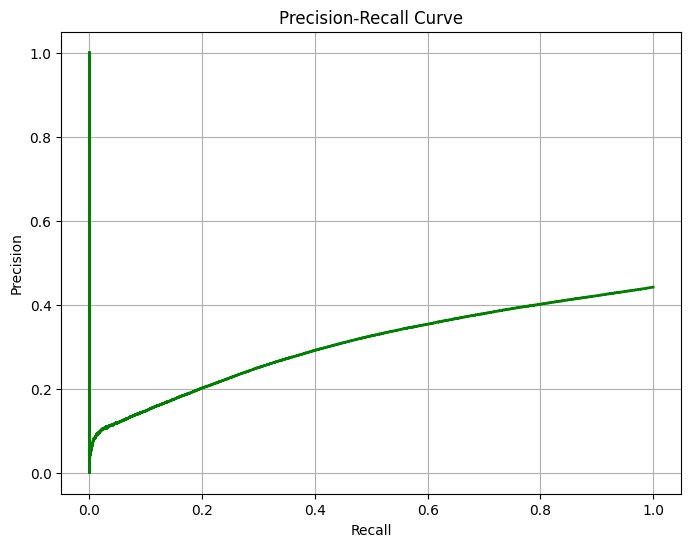

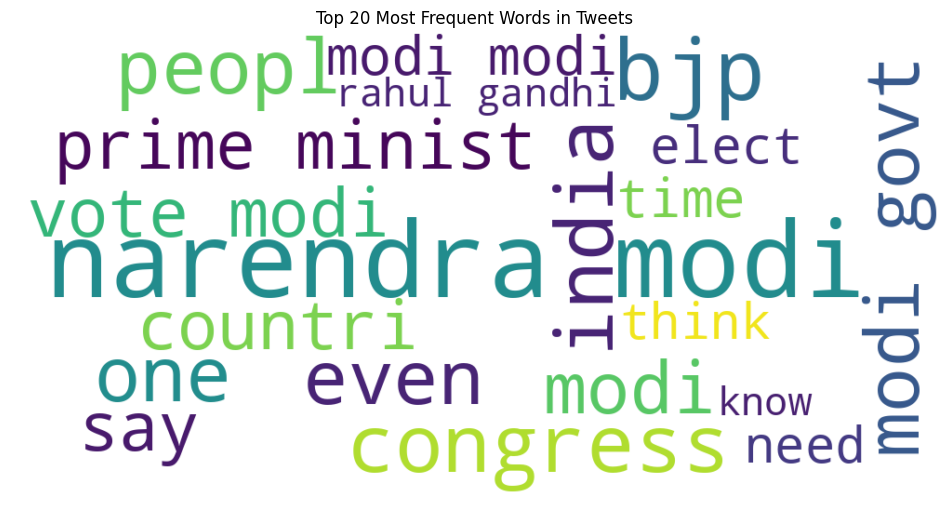

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Download NLTK resources (if not already installed)
nltk.download('stopwords')

# Load the dataset
df = pd.read_csv("/content/Twitter_Data.csv")

# Preview the dataset
print(df.head())

# Step 1: Preprocessing the Text
def preprocess_text(text):
    # Check if the input is a string
    if isinstance(text, str):
        # Remove non-alphabetic characters and convert to lower case
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I)
        text = text.lower()

        # Tokenize and remove stop words
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]

        # Stemming (or Lemmatization)
        ps = PorterStemmer()
        words = [ps.stem(word) for word in words]

        return ' '.join(words)
    else:
        # Handle non-string values (e.g., return an empty string)
        return ''

# Apply preprocessing to the text column, handling non-string values
df['clean_text'] = df['clean_text'].apply(preprocess_text)

# Handle NaN values in 'category' column BEFORE assigning to y
df.dropna(subset=['category'], inplace=True)  # Drop rows with NaN in 'category'

# Step 2: Feature Engineering (Convert text to numerical features)
X = df['clean_text']  # Input features (text)
y = df['category']     # Target variable (sentiment labels)

# Convert text data into numerical vectors using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Step 4: Model Building (Naive Bayes classifier for text classification)
model = MultinomialNB()
model.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred = model.predict(X_test)

# Print classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Step 7: Visualization of Sentiment Distribution
sns.countplot(x='category', data=df, palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1, -1], ["Negative", "Neutral", "Positive"])
plt.show()

# --- ADDITIONAL CHARTS BELOW ---

# 1. Word Frequency Distribution (Bar Chart)
all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)
top_20_words = word_freq.most_common(20)

# Create DataFrame for visualization
word_freq_df = pd.DataFrame(top_20_words, columns=["Word", "Frequency"])

# Plot top 20 words
plt.figure(figsize=(10, 6))
sns.barplot(x="Frequency", y="Word", data=word_freq_df, palette="Blues_d")
plt.title("Top 20 Most Frequent Words")
plt.show()

# 2. Word Cloud Visualization
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(df['clean_text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.show()

# 3. ROC Curve (Receiver Operating Characteristic Curve)
# For ROC Curve, we'll treat it as a binary classification problem (negative vs positive).
# Convert categories -1, 0, 1 to binary: 0 = Negative, 1 = Positive
y_bin = y.replace({-1: 0, 1: 1}).loc[y_test.index]
y_pred_bin = pd.Series(y_pred).replace({-1: 0, 1: 1})

fpr, tpr, thresholds = roc_curve(y_bin, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_bin, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# 5. Top 20 Words (Most Common) - Word Cloud or Bar Chart
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1000, height=500, max_words=20, background_color="white").generate(' '.join(df['clean_text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()
